In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [3]:
print(os.listdir("../input/"))

['test', 'train.csv', 'sample_submission.csv']


In [4]:
test_folder_files = os.listdir("../input/test")
print(test_folder_files[:10])  # print first 10
print("\nNumber of files in the test folder", len(test_folder_files))

['seg_0b082e.csv', 'seg_9e7dff.csv', 'seg_b6c10d.csv', 'seg_4435bd.csv', 'seg_c09a41.csv', 'seg_31ddc5.csv', 'seg_71238c.csv', 'seg_6a05e7.csv', 'seg_d47aba.csv', 'seg_eea20e.csv']

Number of files in the test folder 2624


In [5]:
test_file = pd.read_csv('../input/test/seg_0b082e.csv')
print("Segment shape", test_file.shape)
test_file.head()

Segment shape (150000, 1)


,acoustic_data
0,3
1,10
2,4
3,4
4,1


In [6]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
print("Submission shape", sample_sub.shape)
sample_sub.head()

Submission shape (2624, 2)


,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [7]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 30s, sys: 18.9 s, total: 2min 49s
Wall time: 2min 50s


In [8]:
pd.set_option("display.precision", 15)  # show more decimals
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [9]:
print('The training data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))

The training data has 629145480 rows and 2 columns


In [10]:
from tqdm import tqdm
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    seg = seg[seg.acoustic_data.between(2,30)]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[-1]  # single value
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
    X_train.loc[segment, 'I_ave10%'] = x.values[:int(I_ave10)].mean()
    X_train.loc[segment, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].mean()
    X_train.loc[segment, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].mean()
    X_train.loc[segment, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].mean()
    X_train.loc[segment, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].mean()
    X_train.loc[segment, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].mean()
    X_train.loc[segment, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].mean()
    X_train.loc[segment, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].mean()
    X_train.loc[segment, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].mean()
    X_train.loc[segment, 'X_ave10%'] = x.values[int(IX_ave10):].mean()
    X_train.loc[segment, 'I_ave10%'] = x.values[:int(I_ave10)].std()
    X_train.loc[segment, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].std()
    X_train.loc[segment, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].std()
    X_train.loc[segment, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].std()
    X_train.loc[segment, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].std()
    X_train.loc[segment, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].std()
    X_train.loc[segment, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].std()
    X_train.loc[segment, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].std()
    X_train.loc[segment, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].std()
    X_train.loc[segment, 'X_ave10%'] = x.values[int(IX_ave10):].std()
    
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

100%|██████████| 4194/4194 [09:24<00:00,  7.08it/s]


In [11]:
X = X_train
Y= y_train

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,random_state=123, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3355, 98)
(839, 98)
(3355, 1)
(839, 1)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [14]:
def base_model(l1=100,l2=50):
    model = Sequential()
    model.add(Dense(l1, input_dim=98, kernel_initializer='normal' ,activation='relu'))
    model.add(Dense(l2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_absolute_error', optimizer='RMSprop')
    return model
model = KerasRegressor(build_fn=base_model, verbose=0)
batch_size = [5, 10,20,30]
epochs = [20, 40, 80,100]
l1 = [50, 70, 100]
l2 = [10,20,50]
param_grid = dict(batch_size=batch_size, epochs=epochs, l1=l1, l2=l2)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_absolute_error',n_jobs=-1)
grid_result = grid.fit(X_train, y_train.values)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
   # print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Best: -2.157803 using {'batch_size': 10, 'epochs': 100, 'l1': 100, 'l2': 50}


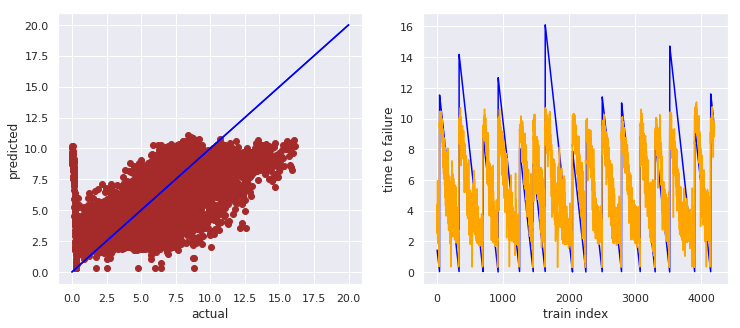

In [15]:
import matplotlib.pyplot as plt
oof_predictions = grid_result.predict(X)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(Y.values, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(Y.values, color='blue')
ax2.plot(oof_predictions, color='orange')

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictions = grid_result.predict(X_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.0372831207634583
r2_score: 0.45601954311752957


In [17]:
def base_model(l1=100,l2=50):
    model = Sequential()
    model.add(Dense(l1, input_dim=98, kernel_initializer='normal' ,activation='sigmoid'))
    model.add(Dense(l2, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_absolute_error', optimizer='Adamax')
    return model
model = KerasRegressor(build_fn=base_model, verbose=0)
batch_size = [5, 10,20,30]
epochs = [20, 40, 80,100]
l1 = [50, 70, 100]
l2 = [10,20,50]
param_grid = dict(batch_size=batch_size, epochs=epochs, l1=l1, l2=l2)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_absolute_error',n_jobs=-1)
grid_result2 = grid.fit(X_train, y_train.values)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
   # print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

Best: -2.157803 using {'batch_size': 10, 'epochs': 100, 'l1': 100, 'l2': 50}


In [18]:
from sklearn.metrics import mean_absolute_error
predictions = grid_result2.predict(X_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.0451885877761
r2_score: 0.4427574029564111


In [19]:
import lightgbm as lgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs6 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs6.fit(X_train, y_train.values.ravel())  
gs6.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 0.8,
 'lambda_l1': 0.1,
 'lambda_l2': 0.4,
 'learning_rate': 0.005,
 'max_depth': 6,
 'min_data_in_leaf': 20,
 'min_gain_to_split': 0.1,
 'num_leaves': 80,
 'random_seed': 34,
 'subsample': 0.85}

In [20]:
predictions =  gs6.predict(X_test)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.08888257607581
r2_score: 0.44338366864798073


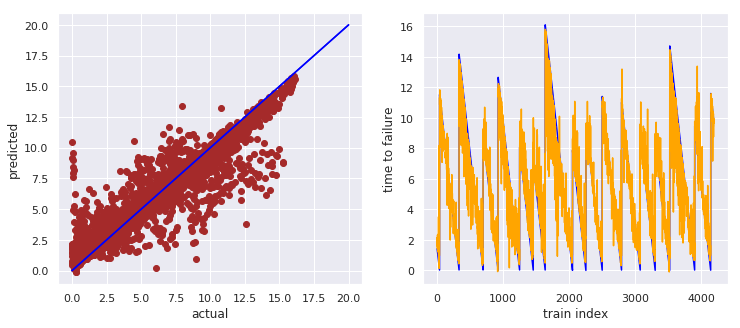

In [21]:
import matplotlib.pyplot as plt
oof_predictions = gs6.predict(X)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(Y.values, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(Y.values, color='blue')
ax2.plot(oof_predictions, color='orange')

In [22]:
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train)
scl_obj.fit(X_test)
X_test_scaled = scl_obj.transform(X_test)
scl_obj.fit(X)
X_scaled = scl_obj.transform(X)

In [23]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs5 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs5.fit(X_train_scaled, y_train.values.ravel())  
gs5.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 1,
 'lambda_l1': 0.4,
 'lambda_l2': 0.4,
 'learning_rate': 0.005,
 'max_depth': 3,
 'min_data_in_leaf': 60,
 'min_gain_to_split': 0.01,
 'num_leaves': 68,
 'random_seed': 13,
 'subsample': 0.8}

In [24]:
predictions =  gs5.predict(X_test_scaled)
print('mean_absolute_error:', mean_absolute_error(y_test, predictions))
print('r2_score:', r2_score(y_test, predictions))

mean_absolute_error: 2.0780861158599735
r2_score: 0.45122999409947795


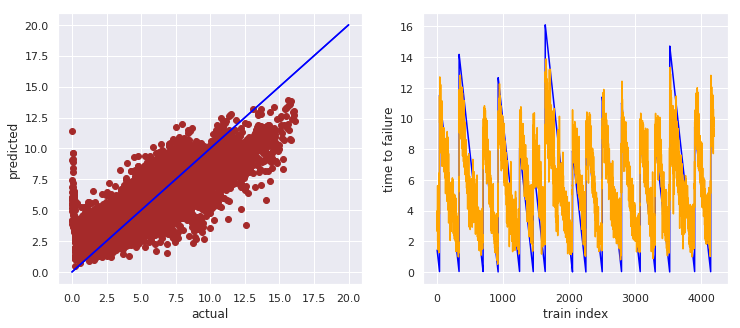

In [25]:
import matplotlib.pyplot as plt
oof_predictions = gs5.predict(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(Y, oof_predictions, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(Y, color='blue')
ax2.plot(oof_predictions, color='orange')

## Submission

In [26]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X.columns, dtype=np.float64, index=submission.index)

In [27]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    seg = seg[seg.acoustic_data.between(2,30)]
    
    x = seg['acoustic_data']  # pd series
         
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
    X_test.loc[seg_id, 'I_ave10%'] = x.values[:int(I_ave10)].mean()
    X_test.loc[seg_id, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].mean()
    X_test.loc[seg_id, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].mean()
    X_test.loc[seg_id, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].mean()
    X_test.loc[seg_id, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].mean()
    X_test.loc[seg_id, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].mean()
    X_test.loc[seg_id, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].mean()
    X_test.loc[seg_id, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].mean()
    X_test.loc[seg_id, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].mean()
    X_test.loc[seg_id, 'X_ave10%'] = x.values[int(IX_ave10):].mean()
    X_test.loc[seg_id, 'I_ave10%'] = x.values[:int(I_ave10)].std()
    X_test.loc[seg_id, 'II_ave10%'] = x.values[int(I_ave10):int(II_ave10)].std()
    X_test.loc[seg_id, 'III_ave10%'] = x.values[int(II_ave10):int(III_ave10)].std()
    X_test.loc[seg_id, 'IV_ave10%'] = x.values[int(III_ave10):int(IV_ave10)].std()
    X_test.loc[seg_id, 'V_ave10%'] = x.values[int(IV_ave10):int(V_ave10)].std()
    X_test.loc[seg_id, 'VI_ave10%'] = x.values[int(V_ave10):int(VI_ave10)].std()
    X_test.loc[seg_id, 'VII_ave10%'] = x.values[int(VI_ave10):int(VII_ave10)].std()
    X_test.loc[seg_id, 'VIII_ave10%'] = x.values[int(VII_ave10):int(VIII_ave10)].std()
    X_test.loc[seg_id, 'IX_ave10%'] = x.values[int(VIII_ave10):int(IX_ave10)].std()
    X_test.loc[seg_id, 'X_ave10%'] = x.values[int(IX_ave10):].std()
    
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
    
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [28]:
X_test.head()

,ave,std,max,min,I_ave10%,II_ave10%,III_ave10%,IV_ave10%,V_ave10%,VI_ave10%,VII_ave10%,VIII_ave10%,IX_ave10%,X_ave10%,q90,q95,q99,q05,q10,q01,abs_max,abs_mean,abs_std,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_std_100,q05_roll_std_100,q10_roll_std_100,q95_roll_std_100,q99_roll_std_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,...,q10_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000,ave_roll_std_10000,std_roll_std_10000,max_roll_std_10000,min_roll_std_10000,ave_roll_mean_10000,std_roll_mean_10000,max_roll_mean_10000,min_roll_mean_10000,q01_roll_std_10000,q05_roll_std_10000,q10_roll_std_10000,q95_roll_std_10000,q99_roll_std_10000,q01_roll_mean_10000,q05_roll_mean_10000,q95_roll_mean_10000,q99_roll_mean_10000,ave_roll_abs_mean_10000,std_roll_abs_mean_10000,max_roll_abs_mean_10000,min_roll_abs_mean_10000,q01_roll_abs_mean_10000,q05_roll_abs_mean_10000,q95_roll_abs_mean_10000,q99_roll_abs_mean_10000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,5.922052405397722,3.275499299682464,30.0,2.0,3.345173255196311,3.387298289945554,2.844220267625661,3.250923650364488,3.269707189436090,3.454567974102841,2.759015856652147,2.544674108802069,3.292442208792478,4.206663738854058,10.0,12.0,18.0,2.0,2.0,2.0,30.0,5.922052405397722,3.275499299682464,2.798150938138353,1.004418343800593,8.668595356489075,1.595796245316491,5.921841314734699,1.406842759359966,16.230000000000000,4.24,1.875170025961088,2.013188836877819,2.098845281375346,4.899273279001718,7.486850425441131,4.64,4.85,8.520000000000000,12.830000000000000,...,2.249660278969893,5.085924756681948,6.344435888619650,4.954,5.065,7.914000000000000,9.205000000000000,5.915515450184222,0.885718559766725,9.835000000000001,4.830,4.954,5.065,7.914000000000000,9.205000000000000,3.158651169395231,0.549197277496530,4.601814561640489,2.328072572363264,5.906119177607270,0.400394494002009,6.9936,5.1742,2.359650160826220,2.421651292093372,2.505073701395804,4.339454410342340,4.586808644619332,5.208400,5.3106,6.590170000000000,6.965300,5.906119177607270,0.400394494002009,6.9936,5.1742,5.208400,5.3106,6.590170000000000,6.965300
seg_0012b5,5.734272777356932,3.335559594075381,30.0,2.0,2.652522693208715,3.578701484662214,4.132156149918114,3.610561986982573,3.359496968417675,3.543726331607472,3.058665749016665,3.151060100351797,3.331512208739841,2.538304430114563,9.0,11.0,19.0,2.0,2.0,2.0,30.0,5.734272777356932,3.335559594075381,2.737167060780584,1.119349297490369,9.205899513821892,1.564085559156706,5.734106867466765,1.571014471749986,17.230000000000000,4.10,1.843470596018222,1.955954389999169,2.025095084436520,5.272330783716629,7.840081165425664,4.46,4.67,8.800000000000001,13.369999999999999,...,2.191317611132494,5.632454468776834,6.797402570573399,4.759,4.939,8.080599999999992,9.625000000000000,5.738798687146714,1.016320375962255,10.557000000000000,4.581,4.759,4.939,8.080599999999992,9.625000000000000,3.325838122670813,0.571828835486831,4.419956062129928,2.412027393628646,5.770017267752356,0.361691521421070,6.6342,5.1755,2.455452529188644,2.583389648930746,2.616064070148494,4.363765716112823,4.380452612333793,5.214800,5.2511,6.481699999999996,6.607232,5.770017267752356,0.361691521421070,6.6342,5.1755,5.214800,5.2511,6.481699999999996,6.607232
seg_00184e,5.901663959041008,3.254422686994555,30.0,2.0,2.755860006629820,3.665281099261429,3.904246131814216,2.885526987403726,3.226279029805071,3.626545715757175,3.332498278319814,3.443941962993319,2.832065270619756,2.430363571412308,10.0,11.0,18.0,2.0,2.0,2.0,30.0,5.901663959041008,3.254422686994555,2.750721916950878,1.0515865671078

In [29]:
submission['time_to_failure'] = grid_result2.predict(X_test)
submission[submission < 0] = 0

In [30]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,4.141399383544922
seg_0012b5,4.955554962158203
seg_00184e,5.332365989685059
seg_003339,8.673965454101562
seg_0042cc,5.151388168334961


In [31]:
submission.to_csv('submission_Neural Network.csv')